<a href="https://colab.research.google.com/github/cosimo-schiavoni/Statistical-Methods-for-Machine-Learning/blob/main/Cats_Dogs_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load necessary libraries.

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from functools import reduce
from google.colab import files
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy
from os import makedirs
from shutil import rmtree
from os.path import join
from os import listdir, rmdir
from shutil import move
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import sklearn.model_selection as sklrn
import pandas as pd
import os
import zipfile

Download the dataset from the remote repository.

In [2]:
os.environ["data_source"] = "./Cats_Dogs_data"

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "download" not in os.listdir():
    if "download.zip" not in os.listdir():
      ! wget https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download/CatsDogs.zip
      with zipfile.ZipFile("CatsDogs.zip", 'r') as f:
        f.extractall("CatsDogs")
    os.remove("CatsDogs.zip")

!mv "./CatsDogs/CatsDogs/Cats" "./Cats_Dogs_data"
!mv "./CatsDogs/CatsDogs/Dogs" "./Cats_Dogs_data"

!rm -rf CatsDogs

--2022-08-05 17:40:19--  https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download/CatsDogs.zip
Resolving unimibox.unimi.it (unimibox.unimi.it)... 159.149.53.190
Connecting to unimibox.unimi.it (unimibox.unimi.it)|159.149.53.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘CatsDogs.zip’

CatsDogs.zip            [         <=>        ] 812.79M   828KB/s    in 3m 55s  

2022-08-05 17:44:16 (3.46 MB/s) - ‘CatsDogs.zip’ saved [852272294]



Convert images to RGB.

In [3]:
def check_channels(s_dir):
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:     
                try:
                  f_path=os.path.join (klass_path,f)        
                  im = Image.open(f_path)
                  rgb_im = im.convert("RGB")
                  os.remove(f_path)
                  rgb_im.save(f_path)
                except:
                  os.remove(f_path)

source_dir =r'./Cats_Dogs_data'
check_channels(source_dir)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Assign a label to each file. The label is pointed out in the tite. 

In [4]:
for root, dirs, files in os.walk(os.environ["data_source"]):
    if not files:
        continue
    prefix = os.path.basename(root)
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f)))


Merge the "Cats" and "Dogs" subfolders into the main folder.

In [5]:
for (root, dirs, file) in os.walk(os.environ["data_source"]):
  for d in dirs:
    for f in files:
      try:
        move(join(os.environ["data_source"],d,d+'_'+f), join(os.environ["data_source"],d+'_'+f))
      except:
        next


!rm -rf "./Cats_Dogs_data/Cats"
!rm -rf "./Cats_Dogs_data/Dogs"


Count number of Cats and Dogs images.

In [6]:
list_of_fnames = os.listdir('./Cats_Dogs_data')
print('Total number of of images in tmp/train is {0}'.format(len(list_of_fnames)))
list_of_cats_fnames = [i for i in list_of_fnames if 'CAT' in i.upper()]
list_of_dogs_fnames = [i for i in list_of_fnames if 'DOG' in i.upper()]
TOTAL_CATS = len(list_of_cats_fnames)
TOTAL_DOGS = len(list_of_dogs_fnames)
print('{0} CATS images'.format(TOTAL_CATS))
print('{0} DOGS images'.format(TOTAL_DOGS))

Total number of of images in tmp/train is 24997
12499 CATS images
12498 DOGS images


Prepare the folders to split Train and Test data.

In [7]:
os.makedirs(os.path.join(os.environ["data_source"], 'train//Cats'))
os.makedirs(os.path.join(os.environ["data_source"], 'test_0//Cats'))
os.makedirs(os.path.join(os.environ["data_source"], 'train//Dogs'))
os.makedirs(os.path.join(os.environ["data_source"], 'test_0//Dogs'))
train_dir = os.path.join(os.environ["data_source"], 'train')
test_dir_cats = os.path.join(os.environ["data_source"], 'test_0//Cats')
test_dir_dogs = os.path.join(os.environ["data_source"], 'test_0//Dogs')


Define global variables to set model parameters.

In [8]:
TRAIN_TEST_SPLIT_AT = 0.7
BATCH_SIZE = 64
TARGET_SIZE = (160, 160)
NO_OF_EPOCHS = 15
EXPERIMENT_SIZE = 12500
NO_OF_FOLDS = 5

Organize data into Train and Test folders.

In [9]:
from shutil import copyfile

np.random.shuffle(list_of_cats_fnames)
np.random.shuffle(list_of_dogs_fnames)

tmp_train_dir = os.path.join(os.environ["data_source"])
c = 0
n = 0
for i in list_of_cats_fnames:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(train_dir, i))
    else:
      if len(os.listdir(f'./Cats_Dogs_data/test_{n}/Cats')) < 500:
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(test_dir_cats, i))
      else:
        n += 1
        os.makedirs(os.path.join(os.environ["data_source"], f'test_{n}//Cats'))
        test_dir_cats = os.path.join(os.environ["data_source"], f'test_{n}//Cats')
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(test_dir_cats, i))
    c += 1
    if c >= EXPERIMENT_SIZE:
        break

m = 0
c = 0
for i in list_of_dogs_fnames:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(train_dir, i))
    else:
      if len(os.listdir(f'./Cats_Dogs_data/test_{m}/Dogs')) < 500:
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(test_dir_dogs, i))
      else:
        m += 1
        os.makedirs(os.path.join(os.environ["data_source"], f'test_{m}//Dogs'))
        test_dir_dogs = os.path.join(os.environ["data_source"], f'test_{m}//Dogs')
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(test_dir_dogs, i))
    c += 1
    if c >= EXPERIMENT_SIZE:
        break

print('Total training images :', len(os.listdir(train_dir)))

Total training images : 17502


Define train files and labels.

In [10]:
train_X = [img_fname for img_fname in os.listdir(train_dir)]
train_X = np.array(train_X)

train_labels = [l.split('/')[-1].split('_')[0].strip('0123456789') for l in train_X]
train_labels = np.array(train_labels)
 
print ('Training shape:', train_X.shape, train_labels.shape) 
 
print(train_X[:5], train_labels[:5])

Training shape: (17502,) (17502,)
['Dogs_4449.jpg' 'Dogs_10817.jpg' 'Dogs_13.jpg' 'Dogs_4157.jpg'
 'Dogs_6737.jpg'] ['Dogs' 'Dogs' 'Dogs' 'Dogs' 'Dogs']


Define the CNN model. 

In [11]:
def get_compiled_model():
        ###Create CNN
      ##Initialize the CNN
    cnn = tf.keras.models.Sequential()
     
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu',  input_shape = [160,160,3]))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Flattening
    cnn.add(tf.keras.layers.Flatten())
    #Full Connection
    cnn.add(tf.keras.layers.Dense(units = 256, activation = 'relu'))
    #Output Layer
    cnn.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
    
        ###Training CNN
      ##Compiling the CNN
    cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn


Define Train and Validation datasets, implement the cross-validation technique and the fit command for the CNN model.

In [12]:
def train_and_cross_validate (model, x_data, y_data, n_folds=NO_OF_FOLDS, epochs=NO_OF_EPOCHS, batch_size=BATCH_SIZE):
    # 
    scores = []
    
    #  Loading images through generators
    train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)    
    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    # prepare cross validation
    kfold = sklrn.KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    FoldsSetNo = 0 
    for train_ix, test_ix in kfold.split(x_data):
        print ('Folds Set # {0}'.format(FoldsSetNo))
        # select rows for train and test
        xx_train, yy_train, xx_test, yy_test = \
            x_data[train_ix], y_data[train_ix], x_data[test_ix], y_data[test_ix]

     # flow training images in batches for the current folds set
        # for training         
        train_generator = train_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_train,'label':yy_train}), 
            directory=train_dir, 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=TARGET_SIZE,
            class_mode='binary',
            shuffle = False)
        
                # and for validation         
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_test,'label':yy_test}), 
            directory=train_dir, 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=TARGET_SIZE,
            class_mode='binary',
            shuffle=False)


        # fit the model
        history = model.fit(train_generator,
                            epochs=epochs,  # The more we train the more our model fits the data
                            batch_size=batch_size,  # Smaller batch sizes = samller steps towards convergence
                            validation_data=validation_generator,
                            verbose=1)
        # store scores
        scores.append({'acc':np.average(history.history['accuracy']),'val_acc':np.average(history.history['val_accuracy']),'loss':np.average(history.history['loss']),'val_loss':np.average(history.history['val_loss'])})
        FoldsSetNo +=1
    return scores
print('Starting training and k-fold cross validation ...')
       


Starting training and k-fold cross validation ...


Retrieve the compiled CNN Model and run the validation command.

In [13]:
model = get_compiled_model()
scores = train_and_cross_validate(model, train_X, train_labels)

Folds Set # 0
Found 13999 validated image filenames belonging to 2 classes.
Found 3501 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/15
219/219 [==============================] - 131s 542ms/step - loss: 0.6740 - accuracy: 0.5603 - val_loss: 0.6388 - val_accuracy: 0.6153
Epoch 2/15
219/219 [==============================] - 116s 529ms/step - loss: 0.6237 - accuracy: 0.6443 - val_loss: 0.5773 - val_accuracy: 0.6972
Epoch 3/15
219/219 [==============================] - 116s 530ms/step - loss: 0.5843 - accuracy: 0.6880 - val_loss: 0.5458 - val_accuracy: 0.7229
Epoch 4/15
219/219 [==============================] - 116s 528ms/step - loss: 0.5655 - accuracy: 0.7073 - val_loss: 0.5299 - val_accuracy: 0.7275
Epoch 5/15
219/219 [==============================] - 116s 529ms/step - loss: 0.5575 - accuracy: 0.7095 - val_loss: 0.5187 - val_accuracy: 0.7461
Epoch 6/15
219/219 [==============================] - 116s 530ms/step - loss: 0.5485 - accuracy: 0.7216 - val_loss: 0.5468 - val_accuracy: 0.7195
Epoch 7/15
219/219 [==============================] - 116s 529ms/step - loss: 0.5400 - accuracy: 0.7219 - val_loss: 0.5270 -

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/15
219/219 [==============================] - 115s 525ms/step - loss: 0.4805 - accuracy: 0.7684 - val_loss: 0.4131 - val_accuracy: 0.8169
Epoch 2/15
219/219 [==============================] - 114s 521ms/step - loss: 0.4711 - accuracy: 0.7717 - val_loss: 0.4040 - val_accuracy: 0.8206
Epoch 3/15
219/219 [==============================] - 114s 521ms/step - loss: 0.4669 - accuracy: 0.7776 - val_loss: 0.3948 - val_accuracy: 0.8249
Epoch 4/15
219/219 [==============================] - 114s 522ms/step - loss: 0.4600 - accuracy: 0.7815 - val_loss: 0.3780 - val_accuracy: 0.8306
Epoch 5/15
219/219 [==============================] - 114s 520ms/step - loss: 0.4543 - accuracy: 0.7818 - val_loss: 0.3892 - val_accuracy: 0.8251
Epoch 6/15
219/219 [==============================] - 114s 521ms/step - loss: 0.4530 - accuracy: 0.7836 - val_loss: 0.4178 - val_accuracy: 0.8006
Epoch 7/15
219/219 [==============================] - 114s 521ms/step - loss: 0.4487 - accuracy: 0.7886 - val_loss: 0.3969 -

Plot the Train and Validation loss and accuracy graph.

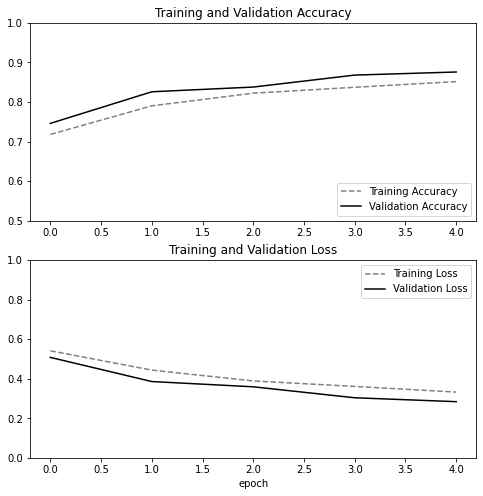

In [14]:
from matplotlib import pyplot as plt

# summarize history for accuracy
# print(scores)
acc = []
val_acc = []
loss_ = []
val_loss_ = []

for s in scores:
    acc.append(s['acc'])
    val_acc.append(s['val_acc'])
    loss_.append(s['loss'])
    val_loss_.append(s['val_loss'])    


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
plt.plot(val_acc, label='Validation Accuracy', color = 'black')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
plt.plot(val_loss_, label='Validation Loss', color = 'black')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Split raw data and labels from test dataset and predict binary classification using the trained model.

In [15]:
evalutaion_batch_size =1000

y_true = []
y_pred = []
#y_pred_NEW = []
#y_true_NEW = []

for i in range(n+1):
  evaluation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      f'.//Cats_Dogs_data//test_{i}',
      shuffle=True,
      batch_size = evalutaion_batch_size,
      image_size = (160,160))
  
  image_batch, label_batch = evaluation_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()
  
  image_batch = tf.where(predictions > 0.51, 1, 0)
  #y_pred.append(image_batch)
  #y_true.append(label_batch)
  y_pred = np.concatenate((y_pred, image_batch), axis = 0)
  y_true = np.concatenate((y_true, label_batch), axis = 0)

Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 497 files belonging to 2 classes.


Compare predicted values and real label, compute the performance of the model employing the zero one loss function

In [16]:
from sklearn.metrics import zero_one_loss

zero_one_loss(y_true, y_pred, normalize=True)

0.2701080432172869

Found 1000 files belonging to 2 classes.
Predictions:
 [1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0
 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1
 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1
 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0
 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1
 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1
 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0
 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1
 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 

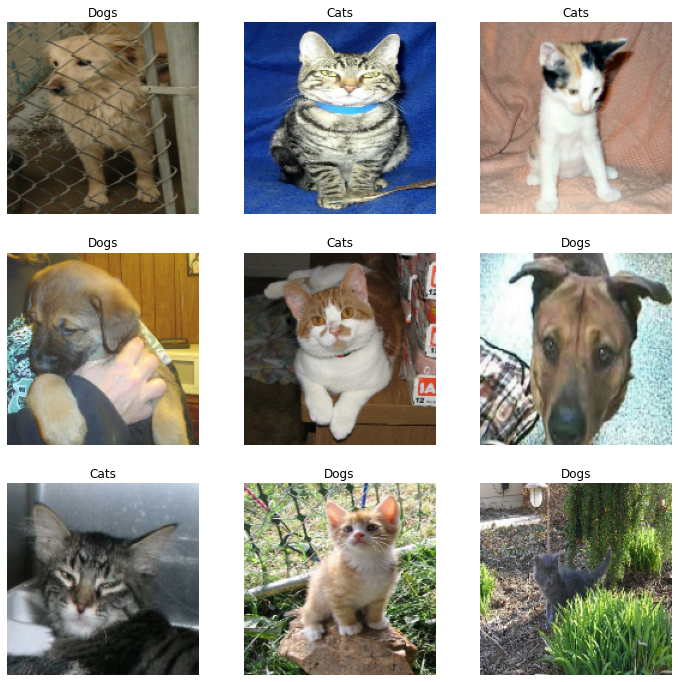

In [20]:
evalutaion_batch_size =1000


class_names = ['Cats','Dogs']

evaluation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './/Cats_Dogs_data//test_0',
    shuffle=True,
    seed = 356723,
    batch_size = evalutaion_batch_size,
    image_size = (160,160))
  
image_batch, label_batch = evaluation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
  
#image_batch = tf.where(predictions > 0.51, 1, 0)
  #y_pred.append(image_batch)
  #y_true.append(label_batch)
  #y_pred = np.concatenate((y_pred, image_batch), axis = 0)
  #y_true = np.concatenate((y_true, label_batch), axis = 0)


#predictions = (predictions - min(predictions)) / ( max(predictions)- min(predictions))
#predictions = np.random.uniform(-1, 1,12)
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions > 0.51, 1, 0)


print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")